In [ ]:
##### SAMPLE CODE #######################################
#mount googledrive
import torch
import time
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# location on Google Drive
master_path = '/content/gdrive/My Drive/Colab Notebooks/Group Project/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


14114


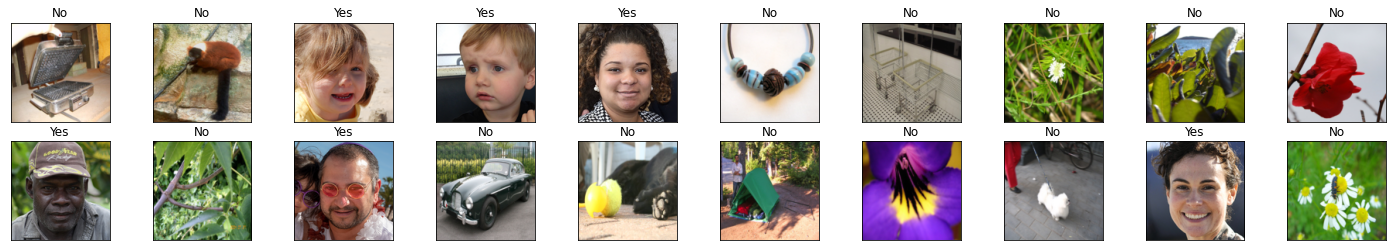

In [ ]:
#By making this a function call I can easily modify batch size later on in my code
def getDataLoaderFull( batch_size=1):

  #classes are folders in each directory with these names
  classes = [ 'No','Yes']

  # location on Google Drive
  master_path = '/content/gdrive/My Drive/Colab Notebooks/Group Project/original_images/LargeSet'

  # Transform Settings - Do not use RandomResizedCrop
  transform = transforms.Compose([transforms.Resize((128,128)), 
                                  transforms.ToTensor()])

  # assumes three folders with 60% training, 20% validation and 20% testing samples
  train_dataset = torchvision.datasets.ImageFolder(master_path , transform=transform)
  # val_dataset = torchvision.datasets.ImageFolder(master_path + 'validation', transform=transform)
  # test_dataset = torchvision.datasets.ImageFolder(master_path + 'testing', transform=transform)
  # overfitting_data = torchvision.datasets.ImageFolder(master_path + 'sanity', transform=transform)

  '''
  indices = np.arange(len(train_dataset))
  np.random.shuffle(indices)
  split = int(len(indices)*0.8)
  trainIndices, valIndices = indices[:split], indices[split:]
  train_sampler = SubsetRandomSampler(trainIndices)
  val_sampler = SubsetRandomSampler(valIndices)
  '''
  totSize = len(train_dataset)
  print(totSize)
  splitRatio = 0.2
  trainSize = int(totSize*splitRatio)
  train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [trainSize, totSize - trainSize])
  valSize = 150
  val_dataset, _ = torch.utils.data.random_split(val_dataset, [valSize, len(val_dataset) - valSize])
  # Prepare Dataloader
  num_workers = 0

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                            num_workers=num_workers)

  val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, 
                                            num_workers=num_workers)

  # test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, 
  #                                           num_workers=num_workers, shuffle=True)

  return train_loader, val_loader #, test_loader

# print(os.getcwd())
# master_path = '/content/gdrive/My Drive/Colab Notebooks/Group Project'

# os.chdir(master_path)
# print(os.getcwd())

train_loader, val_loader = getDataLoaderFull (32)

# Visualize some sample data
classes = ['No','Yes']

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
# print(images, labels)
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])




In [ ]:
class classifierNet(nn.Module):
    def __init__(self, channels1 = 5, channels2 = 10, hiddenSize1 = 40,name='classifier'):
        super(classifierNet, self).__init__()
        self.name = name
        self.conv1 = nn.Conv2d(3, channels1, 5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(channels1, channels2, 4, stride=2)
        self.conv3 = nn.Conv2d(channels2, 10, 3, stride=1)
        self.pool3 = nn.MaxPool2d(3,2)
        self.fc1 = nn.Linear(14 * 14 * 10, hiddenSize1)
        self.fc2 = nn.Linear(hiddenSize1, 10)
        self.fc3 = nn.Linear(10, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = x.view(-1, 10 * 14 * 14)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        x = x.squeeze(1) # Flatten to [batch_size]
        return x


In [ ]:
faceClassifier=classifierNet(channels1=7,channels2=15,hiddenSize1=80,name='net_7_15_80')
faceClassifier.cuda()
faceClassifier.load_state_dict(torch.load('/content/gdrive/My Drive/Colab Notebooks/Group Project/Primary_model_parameters/classifier_50'))
faceClassifier.eval()
print('loaded')

loaded


In [ ]:
from google.colab.patches import cv2_imshow
import cv2 as cv
from PIL import Image
from matplotlib.pyplot import imshow
import torchvision.transforms.functional as functional
import glob


def DetectFaces(folderpath, savepath, margin, threshold, debug = False):
  pathLen = len(folderpath)
  count = 0
  for file in glob.glob(folderpath + "/*.jpg"):
    count += 1
  if(input("About to process {} images. Continue? (y/n): ".format(count)) == 'n'):
    return

  for file in glob.glob(folderpath + "/*.jpg"):
    print("Processing", file[pathLen+1:], end=" ")
    #open image with CV to pass into Viola Jones
    original_image = cv.imread(file)
    print(".", end="")
    #turn to greyscale
    img = cv.cvtColor(original_image, cv.COLOR_BGR2GRAY)
    print(".", end="")
    #pass into Viola Jones
    face_cascade = cv.CascadeClassifier(cv.data.haarcascades + "haarcascade_frontalface_default.xml")
    detected_faces = face_cascade.detectMultiScale(img)
    #detected_faces2 = face_cascade.detectMultiScale(img, scaleFactor=1.05)
    print(".", end="")
    if debug:
      print(detected_faces)


    #open the image in PIL to allow passing into our model
    PIL_image = Image.open(file)
    FaceCount = 0
    recognizedFaces = []
    #for each detected face, pass through our classifier
    for (column, row, width, height) in detected_faces:
      print(".", end="")
      #add margins to increase visible field
      left = max(int(column - width*margin), 0)
      right = min(int(column + width*(1+margin)), PIL_image.size[0])
      top = max(int(row - height*margin), 0)
      bottom = min(int(row + height*(1+margin)), PIL_image.size[1])
      if column + width*(1+margin) > PIL_image.size[0]:
        left = column
        right = column + width
      if bottom + height*(1+margin) > PIL_image.size[1]:
        top = row
        bottom = row + height
      #crop bounding box
      temp = (PIL_image.crop((left, top, right, bottom)))

      #convert into format that can be passed into model
      x = functional.to_tensor(temp.resize((128,128)))
      x.unsqueeze_(0)
      x = x.cuda()

      #pass into our model
      result = faceClassifier(x)
      if(result.data[0].item() > threshold):
        recognizedFaces.append((column, row, width, height, result.data[0].item()))
        color = (0, 255, 0)
        FaceCount +=1
      else:
        color = (0, 0, 255)

      #add the bounding box with the classified color
      cv.rectangle(
          original_image,
          (left, top),
          (right, bottom),
          color,
          8
      )



    #check for overlapping bounding boxes with faces
    #centers = []
    #for (column, row, width, height, certainty) in recognizedFaces:
         
    
    #save edited image with new name

    savename = savepath + file[pathLen:-4]+"_processed.jpg"
    print(" finished!")
    print("{} faces were found".format(FaceCount))
    if (cv.imwrite(savename, original_image)):
      print("Saved as:", file[pathLen+1:-4]+"_processed.jpg")
    else:
      print("could not save!!!")
    print('')

    



#cv2_imshow(original_image)
#cv.waitKey(0)
#cv.destroyAllWindows()

In [ ]:
folderPth = "/content/gdrive/My Drive/Colab Notebooks/Group Project/ViolaTest"
savePth = "/content/gdrive/My Drive/Colab Notebooks/Group Project/ViolaTestResults4"
tempPth = "/content/test"
margin = 0.25
threshold = 0.8
DetectFaces(tempPth, tempPth, margin, threshold)

About to process 1 images. Continue? (y/n): y
Processing R16.jpg ......... finished!
4 faces were found
Saved as: R16_processed.jpg



In [ ]:
def DetectFacesTemp(folderpath, savepath, margin, threshold, debug = False):
  pathLen = len(folderpath)
  count = 0
  for file in glob.glob(folderpath + "/*.jpg"):
    count += 1
  if(input("About to process {} images. Continue? (y/n): ".format(count)) == 'n'):
    return

  for file in glob.glob(folderpath + "/*.jpg"):
    print("Processing", file[pathLen+1:], end=" ")
    #open image with CV to pass into Viola Jones
    original_image = cv.imread(file)
    print(".", end="")
    #turn to greyscale
    img = cv.cvtColor(original_image, cv.COLOR_BGR2GRAY)
    print(".", end="")
    #pass into Viola Jones
    face_cascade = cv.CascadeClassifier(cv.data.haarcascades + "haarcascade_frontalface_default.xml")
    detected_faces = face_cascade.detectMultiScale(img)
    #detected_faces2 = face_cascade.detectMultiScale(img, scaleFactor=1.05)
    print(".", end="")
    if debug:
      print(detected_faces)
    PIL_image = Image.open(file)
    j = 1
    FaceCount = 0
    for (column, row, width, height) in detected_faces:
      left = max(int(column - width*margin), 0)
      right = min(int(column + width*(1+margin)), PIL_image.size[0])
      top = max(int(row - height*margin), 0)
      bottom = min(int(row + height*(1+margin)), PIL_image.size[1])
      temp = (PIL_image.crop((left, top, right, bottom)))
      '''
      x = functional.to_tensor(temp.resize((128,128)))
      x.unsqueeze_(0)
      x = x.cuda()

      #pass into our model
      result = faceClassifier(x)
      print("box {}".format(j), result.data[0].item())
      temp.save(savepath + file[pathLen:-4]+"_box_{}.jpg".format(j))
      '''
      cv.rectangle(
          original_image,
          (left, top),
          (right, bottom),
          (0, 0, 0),
          8
      )
      j+=1


    '''
    #open the image in PIL to allow passing into our model
    PIL_image = Image.open(file)
    count = 0
    recognizedFaces = []
    #for each detected face, pass through our classifier
    for (column, row, width, height) in detected_faces:
      print(".", end="")
      #add margins to increase visible field
      left = max(int(column - width*margin), 0)
      right = min(int(column + width*(1+margin)), PIL_image.size[0])
      top = max(int(row - height*margin), 0)
      bottom = min(int(row + height*(1+margin)), PIL_image.size[1])
      if column + width*(1+margin) > PIL_image.size[0]:
        left = column
        right = column + width
      if bottom + height*(1+margin) > PIL_image.size[1]:
        top = row
        bottom = row + height
      #crop bounding box
      temp = (PIL_image.crop((left, top, right, bottom)))

      #convert into format that can be passed into model
      x = functional.to_tensor(temp.resize((128,128)))
      x.unsqueeze_(0)
      x = x.cuda()

      #pass into our model
      result = faceClassifier(x)
      if(result.data[0].item() > threshold):
        recognizedFaces.append((column, row, width, height, result.data[0].item()))
        color = (0, 255, 0)
        count +=1
      else:
        color = (0, 0, 255)

      #add the bounding box with the classified color
      cv.rectangle(
          original_image,
          (left, top),
          (right, bottom),
          color,
          2
      )



    #check for overlapping bounding boxes with faces
    #centers = []
    #for (column, row, width, height, certainty) in recognizedFaces:
         
    '''
    #save edited image with new name

    savename = savepath + file[pathLen:-4]+"_processed.jpg"
    print(" finished!")
    print("{} faces were found".format(FaceCount))
    if (cv.imwrite(savename, original_image)):
      print("Saved as:", file[pathLen+1:-4]+"_processed.jpg")
    else:
      print("could not save!!!")
    print('')


In [ ]:
tempPth = "/content/test"
margin = 0.25
threshold = 0.4
DetectFaces(tempPth, tempPth, margin, threshold)


About to process 1 images. Continue? (y/n): y
Processing test.jpg ................................. finished!
19 faces were found
Saved as: test_processed.jpg

